# Informed Search Algorithms

Informed search algorithms differ from blind search algorithms in the sense that the goal state is already known. Additionally, the algorithms use knowledge during the search in order to guide the search. This knowledge can take the form of distance to target, or incurred costs.

In [1]:
# Setup the Graph, origin, and destination
import osmnx
from smart_mobility_utilities.common import Node
from smart_mobility_utilities.viz import draw_route

reference = (43.661667, -79.395)
G = osmnx.graph_from_point(reference, dist=500, clean_periphery=True, simplify=True)
origin = Node(graph=G, osmid=1907446268)
destination = Node(graph=G, osmid=1633421938)

---

## Hill Climbing

The idea of the algorithm is quite simple: 

Starting with a known (non-optimized) solution to a function, the algorithm checks the neighbours of that solution, and chooses the neighbour that is "more" optimized. The process is repeated until no "better" solution can be found, at which point the algorithm terminates.

While the algorithm works relatively well with **convex** problems, functions with multiple local maxima will often result in an answer that is not the global maximum. It also performs poorly when there are plateaus (a local set of solutions that are all similarly optimized).

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>HILL-CLIMBING</b>(<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">current</font></i> &larr; random <i>route</i> from <i>source</i> to <i>destination</i><br>
        <i><font color="orange">neighbours</font></i> &larr; children of <i><font color="green">current</font></i><br><br>
        while min(<i><font color="orange">neighbours</font></i>) < <i><font color="green">current</font></i> do
        <div style='padding-left:20px;'>
            <i><font color="green">current</font></i> &larr; min(<i><font color="orange">neighbours</font></i>)<br>
            <i><font color="orange">neighbours</font></i> &larr; children of <i><font color="green">current</font></i>
        </div>
        return <i><font color="green">current</font></i>
    </div>
</div>
<br><br>

Here, we introduce a few new ideas. 

First, we treat the route between two nodes as a function, the value of which is the distance between the two nodes.
Second, we generate "children" of this function.

---

### The function
We need to define a function $f$ that is our target for optimization. <br><br>
$f(x)$ gives us the length of a route for some given route $x \in Y$, where $Y$ is the set of all possible routes between two specific nodes.

How do we generate $x$? We could just generate random permutations between the two nodes, filtering for permutations that are feasible, and optimize $f$ over these random, sparse permutations.

However, this method is not reproducible (because the permutations change every run).

Instead, we make a deterministic policy that generates a number of $x \in Y$ by successively "failing" nodes between the source and destination nodes. We then find the shortest path between the nodes before and after the "failed" nodes. 

By failing the nodes in a deterministic fashion, we can say that we have a function and neighbourhood with defined size for a certain value so we can "rigorously" conduct a local search.

To generate our initial route and children routes, we will use the `smart_mobility_utilities` package. You can see how these routes are generated by consulting the documentation for that package.

:::{note}
The implementation below uses a function called `get_children` which is located in the `smart_mobility_utilities.children` library. It offers both normal and multiprocessed versions in order to speed up processing time. 

We will be using the multiprocessing version of the function, as it performs with approximately 80% processing time reduction.
:::

Initial cost: 1276.422
Initial min(children): 1082.48
Current cost: 1082.48 | min(children): 1076.86
Current cost: 1076.86 | min(children): 1082.48
Final cost: 1076.86


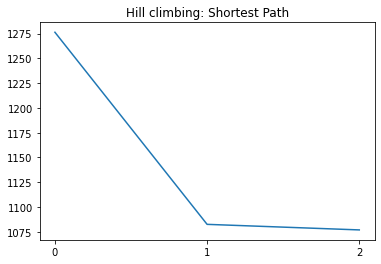

In [2]:
from smart_mobility_utilities.common import randomized_search, cost
from smart_mobility_utilities.children import get_children
import matplotlib.pyplot as plt

# Visualize the costs over time
costs = []
# Set the number of children to generate
num_children = 20

current = randomized_search(G, origin.osmid, destination.osmid)
costs.append(cost(G,current))
print("Initial cost:",costs[0])

neighbours = get_children(G,current,num_children=num_children, multiprocessing=True, workers=6)
shortest = min(neighbours , key = lambda route : cost(G, route))

print("Initial min(children):",cost(G,shortest))
while cost(G, shortest) < cost(G, current):
    current = shortest
    neighbours = get_children(G,current,num_children=num_children, multiprocessing=True, workers=6)
    shortest = min(neighbours , key = lambda route : cost(G, route))
    costs.append(cost(G,current))
    print(f"Current cost:",costs[-1],"|","min(children):",cost(G, shortest))

route = current

plt.xticks(range(len(costs)))
plt.title("Hill climbing: Shortest Path")
p = plt.plot(costs)
print("Final cost:",costs[-1])



In [3]:
draw_route(G,route)

KeyboardInterrupt: 

While the implementation above is deterministic in nature, the initial route is still randomized. That means that it's possible to get different results across runs.

Hill climbing will generally return some decent results as there are few local optimal points in the route function. However, with larger search spaces that will naturally have more local maxima and plateaus, it will get stuck fairly quickly.

---

## Beam Search

While Hill Climbing maintains a single "best" state throughout the run, beam search keeps $k$ states in memory. At each iterations, it generates the neighbours for each of the $k$ states, and puts them into a pool with the $k$ states from the original beam. It then selects the best $k$ routes from the pool to become the new beam, and this process repeats. The algorithm terminates when the new beam is equal to the old beam. As it is a local search algorithm, it is also susceptible to being stuck at local maxima.

A beam search with $k=\infty$ is the same as a BFS. Because there is the risk that a state that would lead to the optimal solution might get discarded, beam searches are considered to be incomplete (it may not terminate with the solution).

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>BEAM-SEARCH</b>(<i>source</i>,<i>destination</i>,<i>k</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">seen</font></i> &larr; <i>nil</i><br>
        <i><font color="orange">beam</font></i> &larr; random <i>k</i> routes from <i>source</i> to <i>destination</i><br>
        add <i><font color="orange">beam</font></i> to <i><font color="green">seen</font></i><br>
        <i><font color="purple">pool</font></i> &larr; children of routes in the <i><font color="orange">beam</font></i> with consideration of <i><font color="green">seen</font></i> + <i><font color="orange">beam</font></i><br>
        <i><font color="grey">last_beam</font></i> &larr; <i>nil</i><br><br>
        while <i><font color="orange">beam</font></i> is not <i><font color="grey">last_beam</font></i> do
        <div style='padding-left:20px;'>
            <i><font color="grey">last_beam</font></i> &larr; <i><font color="orange">beam</font></i><br>
            <i><font color="orange">beam</font></i> &larr; the best <i>k</i> routes from <i><font color="purple">pool</font></i><br>
            add <i><font color="orange">beam</font></i> to <i><font color="green">seen</font></i><br>
            <i><font color="purple">pool</font></i> &larr; children of routes in the <i><font color="orange">beam</font></i> with consideration of <i><font color="green">seen</font></i> + <i><font color="orange">beam</font></i>
        </div>
        <b>return</b> optimal <i>route</i> in <i><font color="orange">beam</font></i>
    </div>
</div>
<br><br>

:::{note}
The implementation below uses a function called `get_beam` which is located in the `smart_mobility_utilities.children` library. It offers both normal and multiprocessed versions in order to speed up processing time. 

We will be using the multiprocessing version of the function, as it performs with approximately 50% processing time reduction.
:::

Route: [1907446268, 55808224, 55808227, 8699043521, 55808177, 55808169, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 1258698113, 1258698109, 389678145, 24960070, 24960073, 7311083154, 50885160, 389678121, 50885147, 389678122, 389677906, 50885141, 389678180, 2143436415, 2143436407, 2143436406, 2143436381, 389678041, 389678184, 389678183, 24959556, 389678214, 389678215, 389678226, 1633421933, 1633421938]
Cost: 1059.537


Text(0.5, 1.0, 'Beam Search: Costs vs time')

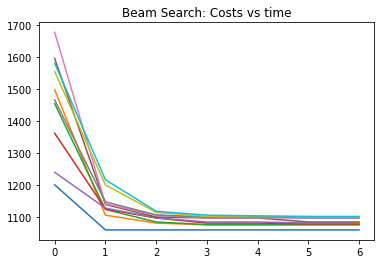

In [ ]:
import heapq
from smart_mobility_utilities.children import get_beam
import matplotlib.pyplot as plt

# Initialize
seen = set()
k = 10
num_neighbours = 10
costs = []

beam = [randomized_search(G,origin.osmid,destination.osmid) for _ in range(k)]

# the seen routes must be converted to a tuple to be hashable to be stored in a set
for route in beam: seen.add(tuple(route))

pool = []
children = get_beam(G,beam,num_neighbours,multiprocessing=True,workers=6)
costs.append([cost(G,r) for r in beam])
for child in children:
    for r in child:
        if tuple(r) in seen: continue
        else: 
            pool.append(r)
            seen.add(tuple(r))
pool += beam
last_beam = None
while beam != last_beam:
    last_beam = beam
    beam = heapq.nsmallest(k, pool, key = lambda route: cost(G, route))
    
    for route in beam: seen.add(tuple(route))    
    
    pool = []
    children = get_beam(G,beam,num_neighbours,multiprocessing=True,workers=6)
    costs.append([cost(G,r) for r in beam])
    for child in children:
        for r in child:
            if tuple(r) in seen: continue
            else: pool.append(r); seen.add(tuple(r))
    pool += beam   
route = min(beam, key = lambda route : cost(G, route)) 


print("Route:",route)
print("Cost:", cost(G,route))

costs = map(list,zip(*costs))
for c in costs:
    plt.plot(c)
plt.title("Beam Search: Costs vs time")

In [ ]:
draw_route(G,route)

Map(center=[43.6611082, -79.3947681], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

---

## A* Search
A* (pronounced A-star) search is an informed search algorithm widely used in pathfinding and graph traversal.

A* works by "greedily" choosing which vertex to explore next, based on a function:

$f(V) = h(V) + g(V)$, where $h$ is a heuristic, and $g$ is the cost accrued up to that point.

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>A* Heuristic</b> &larr; sum of straight-line distance between the node to source and node to destination<br>
    <b>PQ</b> &larr; min heap according to <b>A* Heuristic</b><br><br>
    <b>A*-SEARCH</b>(<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">frontier</font></i> &larr; a <b>PQ</b> initialized with <i>source</i><br>
        <i><font color="grey">explored</font></i> &larr; <i>empty</i><br>
        <i><font color="orange">found</font></i> &larr; <i>False</i><br>
        while <i><font color="green">frontier</font></i> is not <i>empty</i> and <i><font color="orange">found</font></i> is <i>False</i> do
        <div style='padding-left:20px;'>
        <i>node</i> &larr; <i><font color="green">frontier</font></i>.pop()<br>
        add <i>node</i> to <i><font color="grey">explored</font></i><br>
        for <i>child</i> in <i>node</i>.expand() do
            <div style='padding-left:20px;'>
                if <i>child</i> is not in <i><font color="grey">explored</font></i> and <i>child</i> is not in <i><font color="green">frontier</font></i> then
                <div style='padding-left:20px;'>
                if <i>child</i> is <i>destination</i> then
                    <div style='padding-left:20px;'>
                        <i>route</i> &larr; <i>child</i>.route()<br>
                        <i><font color="orange">found</font></i> &larr; <i>True</i>
                    </div>
                add <i>child</i> to <i><font color="green">frontier</font></i>
                </div>
            </div>
        </div>
    return <i>route</i>
    </div>
</div>
<br><br>

### The Heuristic

The driving force behind A* is the selection of a new vertex (or node) to explore based on the lowest heuristic value. This heuristic value is computed by the following formula:

let $dist(x,y)$ be a function that calculates the straight line distance between two nodes $x,y$,<br>
and let $O$ be the origin node, and $D$ be the destination node,

$h(V) = dist(V,O) + dist(V,D)$ for any given node $V$

As the sum of the distance to the origin and destination is minimized when $V$ lies on a straight line from $O$ to $D$, this heuristic prioritizes nodes which are "closer" to the straight-line distance from origin to destination.

:::{note}
The implentation of the A* heuristic in `smart_mobility_utilities` defaults to calculating distances as if the Earth were flat. For local searches, this yields the best results. If the size of the search area is larger, it is better to calculate distance using the `haversine_distance`, which takes into account the curvature of the Earth.

This can be done by setting the distance function like so:<br>
```astar_heuristic(G,origin.osmid,destination.osmid, measuring_dist = haversine_distance)```
:::

In [ ]:
# Get the A* Heuristic for all the nodes in the graph
from smart_mobility_utilities.problem import astar_heuristic

toOrigin, toDestination = astar_heuristic(G, origin.osmid, destination.osmid)

route = []

frontier = list()

frontier.append(origin)
explored = set()
found = False

while frontier and not found:    
    # choose a node based on its heuristic value
    node = min(frontier, key = lambda node : toOrigin[node.osmid] + toDestination[node.osmid])
    frontier.remove(node)
    explored.add(node)
    
    # expand its children
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route = child.path()
                found = True
                continue
            frontier.append(child)

print("The route is ",route)
print("Route cost is", cost(G, route))
draw_route(G,route)

The route is  [1907446268, 55808224, 55808227, 8699043521, 1907446267, 8699033082, 55808301, 6542457312, 4953810914, 55808233, 299625330, 389677953, 7967019556, 7967019555, 390547782, 389678107, 389678111, 389678112, 389678113, 389678146, 2143434862, 2143434860, 7311083158, 1258707987, 389678121, 50885147, 389678122, 1258707990, 7153999189, 389678124, 6028562355, 2557542523, 389677907, 389678038, 389678039, 389678040, 2143436381, 7311057930, 7311057931, 389678216, 389678215, 389678226, 1633421933, 1633421938]
Route cost is 1137.69


Map(center=[43.6611082, -79.3947681], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

---

## Bi-Directional Search
The purpose of bi-directional searches are to run two simultaneous, non-parallel searches; one starts at the origin and the other at the destination, with the goal of meeting somewhere in between.

This approach is more efficient because of the time complexities involved.

For example, a BFS search with a constant branching factor $b$ and depth $d$ would have an overall space complexity of $O(d^b)$. By running two BFS searches in opposite directions with only half the depth ($d/2$), the space complexity becomes instead $O((d/2)^b)+O((d/2)^b)$, which is much lower than the original $O(d^b)$.

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>BI-DIRECTIONAL-SEARCH</b>(<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <font color="#03A9F4">// _f for forward, _b for backward</font><br>
        <i><font color="green">frontier_f</font></i> &larr; initialized with <i>source</i><br>
        <i><font color="green">frontier_b</font></i> &larr; initialized with <i>destination</i><br>
        <i><font color="grey">explored_f</font></i> &larr; <i>empty</i><br>
        <i><font color="grey">explored_b</font></i> &larr; <i>empty</i><br>
        <i><font color="orange">found</font></i> &larr; <i>False</i><br>
        <i><font color="purple">collide</font></i> &larr; <i>False</i> <font color="#03A9F4">// if front overlaps with back</font><br>
        <i><font color="blue">found</font></i> &larr; <i>False</i><br>
        <i><font color="blue">altr_expand</font></i> &larr; <i>False</i><font color="#03A9F4">// expansion direction</font><br><br>
        while <i><font color="green">frontier_f</font></i> is not <i>empty</i> and <i><font color="green">frontier_b</font></i> is not <i>empty</i> and not <i><font color="purple">collide</font></i> and not <i><font color="orange">found</font></i> do
        <div style='padding-left:20px;'>
            if <i><font color="blue">altr_expand</font></i> then
            <div style='padding-left:20px;'>
                <i>node</i> &larr; <i><font color="green">frontier_f</font></i>.pop()<br>
                add <i>node</i> to <i><font color="grey">explored_f</font></i><br>
                for <i>child</i> in <i>node</i>.expand() do
                <div style='padding-left:20px;'>
                    if <i>child</i> in <i><font color="grey">explored_f</font></i> then continue<br>
                    if <i>child</i> is <i>destination</i> then
                        <div style='padding-left:20px;'>
                            <i>route</i> &larr; <i>child</i>.route()<br>
                            <i><font color="orange">found</font></i> &larr; <i>True</i>
                        </div>
                    if <i>child</i> in <i><font color="grey">explored_b</font></i> then
                        <div style='padding-left:20px;'>
                            <i>route</i> &larr; <i>child</i>.route() + reverse(<i>overlapped</i>.route())<br>
                            <i><font color="purple">collide</font></i> &larr; <i>True</i>
                        </div>
                    add <i>child</i> to <i><font color="green">frontier_f</font></i><br>
                    <i><font color="blue">altr_expand</font></i> &larr; not <i><font color="blue">altr_expand</font></i>
                </div>
            </div>
            else
            <div style='padding-left:20px;'>
                <i>node</i> &larr; <i><font color="green">frontier_b</font></i>.pop()<br>
                add <i>node</i> to <i><font color="grey">explored_b</font></i><br>
                for <i>child</i> in <i>node</i>.expand() do
                <div style='padding-left:20px;'>
                    if <i>child</i> in <i><font color="grey">explored_b</font></i> then continue<br>
                    if <i>child</i> is <i>origin</i> then
                        <div style='padding-left:20px;'>
                            <i>route</i> &larr; <i>child</i>.route()<br>
                            <i><font color="orange">found</font></i> &larr; <i>True</i>
                    </div>
                    if <i>child</i> in <i><font color="grey">explored_f</font></i> then
                        <div style='padding-left:20px;'>
                            <i>route</i> &larr; reverse(<i>child</i>.route()) + <i>overlapped</i>.route()<br>
                            <i><font color="purple">collide</font></i> &larr; <i>True</i>
                        </div>
                    add <i>child</i> to <i><font color="green">frontier_b</font></i><br>
                    <i><font color="blue">altr_expand</font></i> &larr; not <i><font color="blue">altr_expand</font></i>
                </div>
            </div>
        </div>
        return <i>route</i>
    </div>
</div>
<br><br>

In [ ]:
# Using A* as search heuristic and algorithm

# define destination and origin for the backwards expansion
destination_b = origin
origin_b = destination

# get A*
toOrigin_f, toDestination_f = astar_heuristic(G, origin.osmid, destination.osmid)
toOrigin_b, toDestination_b = astar_heuristic(G, origin_b.osmid, destination_b.osmid)

route = []

f_value = lambda node: toOrigin_f[node.osmid] + toDestination_f[node.osmid]
b_value = lambda node: toOrigin_b[node.osmid] + toDestination_b[node.osmid]

frontier_f = list()
frontier_b = list()

frontier_f.append(origin)
frontier_b.append(origin_b)

explored_f = list()
explored_b = list()

collide = False
found = False
altr_expand = False # to alternate between front and back

while frontier_f and frontier_b and not collide and not found:
   
    if altr_expand:
        # remove node_f from frontier_f to expand it
        node = min(frontier_f, key = lambda node : f_value(node))
        frontier_f.remove(node)
        explored_f.append(node)
        
        for child in node.expand():
            if child in explored_f: continue
            
            if child == destination:
                route = child.path()
                found = True
                break

            # checking for collusion with the target expansion
            if child in explored_b:
                overlapped = next((node for node in explored_b if node == child))
                # we don't take the overlapped node twice
                route = child.path()[:-1] + overlapped.path()[::-1]
                collide = True
                break

            frontier_f.append(child)
        altr_expand = False
    else:
        # remove node_b from frontier_b to expand it
        node = min(frontier_b, key = lambda node : b_value(node))
        frontier_b.remove(node)
        explored_b.append(node)
        
        for child in node.expand():
            if child in explored_b: continue
            if child == destination_b:
                route = child.path()[::-1] # we reverse the list because we expand from the back
                found = True
                break

            if child in explored_f:
                overlapped = next((node for node in explored_f if node == child), None)
                route = overlapped.path()[:-1] + child.path()[::-1]
                collide = True
                break

            frontier_b.append(child)
        altr_expand = True

print("The route is \n\n",route)
print("Cost of the route:",cost(G,route))
draw_route(G,route)

The route is 

 [1907446268, 55808224, 55808227, 8699043521, 1907446267, 8699033082, 55808301, 6542457312, 4953810914, 55808233, 299625330, 389677953, 7967019556, 7967019555, 390547782, 389678107, 389678111, 389678112, 389678113, 389678146, 2143434862, 2143434860, 7311083158, 1258707987, 389678121, 50885147, 389678122, 1258707990, 7153999189, 389678124, 6028562355, 2557542523, 389677907, 389678038, 389678039, 389678040, 2143436381, 7311057930, 7311057931, 389678216, 389678215, 389678226, 1633421933, 1633421938]
Cost of the route: 1137.69


Map(center=[43.6611082, -79.3947681], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…